In [2]:
# https://github.com/langchain-ai/langchain-mcp-adapters?tab=readme-ov-file#streamable-http

from mcp import ClientSession
from mcp.client.streamable_http import streamablehttp_client

from langchain_mcp_adapters.tools import load_mcp_tools

async with streamablehttp_client("http://127.0.0.1:8000/mcp/") as (read, write, _):
    async with ClientSession(read, write) as session:
        await session.initialize()

        # Get tools
        tools = await load_mcp_tools(session)

        # 'hello' 도구를 비동기적으로 실행하고 결과를 result 변수에 할당
        # MCP는 서버이기 때문에 네트워크로 비동기 통신함
        result = await tools[0].ainvoke({"name": "김일남"})
        print(result)

안녕하세요, 김일남님!


In [3]:
tools

[StructuredTool(name='hello', description='간단한 인사말을 반환하는 도구', args_schema={'properties': {'name': {'default': '아무개', 'title': 'Name', 'type': 'string'}}, 'title': 'helloArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x0000020ECA903C40>),
 StructuredTool(name='get_current_time', description="현재 시각을 반환하는 함수\n\nArgs:\n    timezone (str): 타임존 (예: 'Asia/Seoul') 실제 존재하는 타임존이어야 함\n    location (str): 지역명. 타임존이 모든 지명에 대응되지 않기 때문에 이후 llm 답변 생성에 사용됨\n", args_schema={'properties': {'timezone': {'default': 'Asia/Seoul', 'title': 'Timezone', 'type': 'string'}, 'location': {'default': '부산', 'title': 'Location', 'type': 'string'}}, 'title': 'get_current_timeArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x0000020ECA9036A0>),
 StructuredTool(name='get_yf_stock_history', description='주식 종목의 가격 데이터를 조회하는 

In [4]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient(
    {
        "mcp_tools": {
            "url": "http://localhost:8000/mcp/",
            "transport": "streamable_http",
        }
    }
)
tools = await client.get_tools()

In [5]:
tools

[StructuredTool(name='hello', description='간단한 인사말을 반환하는 도구', args_schema={'properties': {'name': {'default': '아무개', 'title': 'Name', 'type': 'string'}}, 'title': 'helloArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x0000020ECA953EC0>),
 StructuredTool(name='get_current_time', description="현재 시각을 반환하는 함수\n\nArgs:\n    timezone (str): 타임존 (예: 'Asia/Seoul') 실제 존재하는 타임존이어야 함\n    location (str): 지역명. 타임존이 모든 지명에 대응되지 않기 때문에 이후 llm 답변 생성에 사용됨\n", args_schema={'properties': {'timezone': {'default': 'Asia/Seoul', 'title': 'Timezone', 'type': 'string'}, 'location': {'default': '부산', 'title': 'Location', 'type': 'string'}}, 'title': 'get_current_timeArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x0000020EC5259B20>),
 StructuredTool(name='get_yf_stock_history', description='주식 종목의 가격 데이터를 조회하는 

In [6]:
result = await tools[0].ainvoke({"name": "김일남"})
result

'안녕하세요, 김일남님!'

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [8]:
from typing import Annotated # annotated는 타입 힌트를 사용할 때 사용하는 함수
from typing_extensions import TypedDict # TypedDict는 딕셔너리 타입을 정의할 때 사용하는 함수

from langgraph.graph.message import add_messages

# 상태 정의
class State(TypedDict):	
    messages: Annotated[list[str], add_messages]

In [9]:
# * 도구 바인딩
def call_model(state: State):
    response = model.bind_tools(tools).invoke(state["messages"])
    return {"messages": response}

In [10]:
from langgraph.graph import START, END

def route_tools(state: State):
    """
    마지막 메시지에 도구 호출이 있는 경우 ToolNode로 라우팅하고,
    그렇지 않은 경우 END로 라우팅하기 위해 conditional_edge에서 사용합니다.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"tool_edge 입력 상태에서 메시지를 찾을 수 없습니다: {state}")
        
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [11]:
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode

# 그래프 구성
graph_builder = StateGraph(State)

graph_builder.add_node(call_model)
graph_builder.add_node(ToolNode(tools))

graph_builder.add_edge(START, "call_model")
graph_builder.add_conditional_edges(
    "call_model",
    route_tools,
    {"tools": "tools", END: END},
)
graph_builder.add_edge("tools", "call_model")
graph = graph_builder.compile()

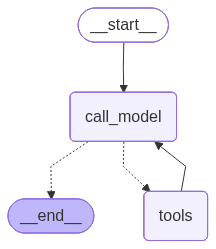

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [13]:
time_response = await graph.ainvoke({"messages": "지금 부산 몇시야?"})
time_response

{'messages': [HumanMessage(content='지금 부산 몇시야?', additional_kwargs={}, response_metadata={}, id='3dd64f6d-5202-4700-9b15-d3b1f74a248a'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_time', 'arguments': '{"location": "\\ubd80\\uc0b0", "timezone": "Asia/Seoul"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--431807ef-27cc-44d8-b3b6-b0364d57e29c-0', tool_calls=[{'name': 'get_current_time', 'args': {'location': '부산', 'timezone': 'Asia/Seoul'}, 'id': 'a0d66de4-a9d9-4246-9471-688846ce94f7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 315, 'output_tokens': 201, 'total_tokens': 516, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 177}}),
  ToolMessage(content='Asia/Seoul (부산) 현재시각 2025-09-27 17:36:13 ', name='get_current_time', id='0464a4f7-0302-453b-a845-8f1a2cc547e7', tool_call_id='a0d66

In [14]:
stock_response = await graph.ainvoke({"messages": "오늘 테슬라 주가 알려줘"})
stock_response

{'messages': [HumanMessage(content='오늘 테슬라 주가 알려줘', additional_kwargs={}, response_metadata={}, id='673b2303-d19f-456a-87bf-cf1e88317790'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_yf_stock_history', 'arguments': '{"stock_history_input": {"ticker": "TSLA", "period": "1d"}}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--6e4e7c6f-3b5e-4fc7-92ef-b3798ba3c686-0', tool_calls=[{'name': 'get_yf_stock_history', 'args': {'stock_history_input': {'ticker': 'TSLA', 'period': '1d'}}, 'id': '775f4e95-1768-4a69-b9db-887849cd62b3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 317, 'output_tokens': 253, 'total_tokens': 570, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 218}}),
  ToolMessage(content='| Date                      |   Open |   High |    Low |   Close |      Volume |   Dividends |   Stock